# Trabalho 2 IART: Aprendizagem Supervisionada - Regressão
## Introdução
O futebol é possivelmente o desporto mais popular de sempre com milhões de adeptos e um igual número de jogadores dado ser talvez um dos desportos mais fáceis de jogar que existe.

Para além disso, este desporto movimenta uma grande quantidade de dinheiro quer pela venda de bilhetes e _merchandise_ quer pelas transferências de jogadores. Outro lado desta economia é o mercado das apostas desportivas que é cada vez mais procurado por adeptos. Sabe-se que os apostadores profissionais acertam na sua aposta cerca de 53% das vezes.

Sendo assim, o objetivo deste trabalho é prever o resultado de jogos de maneira a criar um sistema que recomenda o resultado do jogo em que apostar, preferivelmente com uma precisão superior à dos apostadores profissionais.

## Descrição do _dataset_
O _dataset_ inclui informação acerca de 25000 partidas de futebol em ligas de 11 países europeus realizadas nas épocas de 2008 a 2016 e acerca de 10000 jogadores. Este inclui ainda informação sobre os _odds_ fornecidos por vários _sites_ de apostas para os vários jogos.
Mais informação pode ser encontrada [aqui](https://www.kaggle.com/hugomathien/soccer).

## Aquisição e exploração de dados
O _dataset_ que irá ser usado corresponde a uma base de dados sqlite que inclui as tabelas a seguir apresentadas e que contêm a seguinte informação:

In [33]:
import sqlite3

conn = sqlite3.connect('soccer.db')
cursor = conn.cursor()
cursor.execute("select name from sqlite_master where type='table'; ")
cursor.fetchall()

[('sqlite_sequence',),
 ('Player_Attributes',),
 ('Player',),
 ('Match',),
 ('League',),
 ('Country',),
 ('Team',),
 ('Team_Attributes',)]

* **Country:**  Países para os quais existe informação.
* **League:** Ligas de futebol dos vários países incluídos na tabela _Country_.
* **Match:** Informação sobre as várias partidas de futebol que inclui estatísticas do jogo, _odds_, bem como os jogadores que participaram.
* **Player:** Informação sobre os vários jogadores da base de dados, incluindo nome, data de nascimento, altura e peso.
* **Player_Attributes:** Habilidades de cada um dos jogadores tiradas do jogo FIFA.
* **Team:** Informação acerca de cada uma das equipas, incluindo o seu nome.
* **Team_Attributes:** Habilidades de cada uma das equipas tiradas do jogo FIFA.

Dado tratar-se de um _dataset_ extenso (~300MB) apenas serão consideradas partidas jogadas na English Premier League, já que corresponde a uma liga com um número razoável de equipas e jogos. Sendo assim, os passos seguintes têm como objetivo extrair informação acerca desta liga.

In [282]:
import pandas as pd
from lxml import etree as et

matches = pd.read_sql_query("select League.name, " 
                            "Match.id, Match.season, Match.possession, Match.corner, Match.card, Match.foulcommit as foul, "
                            "Match.shoton, Match.shotoff, T1.team_long_name as home_team, T1.team_api_id as home_team_id, " 
                            "home_team_goal, T2.team_api_id as away_team_id, T2.team_long_name as away_team, " 
                            "Match.away_team_goal, stage, date, B365H, B365D, B365A " 
                            "from League, Match on (League.id = Match.league_id), Team as T1 on (T1.team_api_id = Match.home_team_api_id), " 
                            "Team as T2 on (T2.team_api_id = Match.away_team_api_id) where League.name = 'England Premier League'", conn)
matches

# Get possession XML data
matches['possession'] = matches['possession'].apply(lambda x: et.fromstring(x))
matches['card'] = matches['card'].apply(lambda x: et.fromstring(x))
matches['foul'] = matches['foul'].apply(lambda x: et.fromstring(x))
matches['corner'] = matches['corner'].apply(lambda x: et.fromstring(x))
matches['shoton'] = matches['shoton'].apply(lambda x: et.fromstring(x))
matches['shotoff'] = matches['shotoff'].apply(lambda x: et.fromstring(x))

                        name    id     season  \
0     England Premier League  1729  2008/2009   
1     England Premier League  1730  2008/2009   
2     England Premier League  1731  2008/2009   
3     England Premier League  1732  2008/2009   
4     England Premier League  1733  2008/2009   
...                      ...   ...        ...   
3035  England Premier League  4764  2015/2016   
3036  England Premier League  4765  2015/2016   
3037  England Premier League  4766  2015/2016   
3038  England Premier League  4767  2015/2016   
3039  England Premier League  4768  2015/2016   

                                             possession  \
0     <possession><value><comment>56</comment><event...   
1     <possession><value><comment>65</comment><event...   
2     <possession><value><comment>45</comment><event...   
3     <possession><value><comment>50</comment><event...   
4     <possession><value><comment>51</comment><event...   
...                                                 ...  

Algumas colunas na tabela __Match__ contém valores em XML,como a coluna _possession_. Portanto para obter os valores absolutos da posse de bola de cada equipa é necessário realizar algumas operações.

In [158]:
possession = et.Element("possession")

for id, row in zip(matches['id'], matches['possession']):
    #print(et.tostring(row, pretty_print=True).decode())
    if len(row.getchildren()):
        match = et.SubElement(possession, 'match')
        match.set('id', str(id))
        for child in row[-1].getchildren():
            el = et.fromstring(et.tostring(child))
            match.append(el)

file = open('possession.xml', 'w+')
file.write(et.tostring(possession, pretty_print=True).decode())

idx = 0
for _, element in et.iterparse("possession.xml", tag='match'):
#     print('Match_id: ' + element.get('id'))
#     print('HOME_POS: %s -- AWAY_POS: %s\n' % (element.findtext('homepos'), element.findtext('awaypos')))
    matches.at[idx, "HP"] = element.findtext('homepos')
    matches.at[idx, "AP"] = element.findtext('awaypos')
    
    idx += 1
    element.clear(keep_tail=True)
    
matches.head()

,name,id,season,possession,corner,card,foul,shoton,shotoff,home_team,...,away_team_id,away_team,away_team_goal,stage,date,B365H,B365D,B365A,HP,AP
0,England Premier League,1729,2008/2009,"[[[], [], [], [], [], [], [], [], [], []], [[]...","[[[<Element corners at 0x24ad0ee9d00>], [], []...","[[[], [<Element ycards at 0x24ad0ee9040>], [],...","[[[<Element foulscommitted at 0x24ad0ee9f00>],...","[[[<Element blocked at 0x24ad0ee9f00>], [], []...","[[[<Element shotoff at 0x24ad0eeb080>], [], []...",Manchester United,...,10261,Newcastle United,1,1,2008-08-17 00:00:00,1.29,5.5,11.00,55,45
1,England Premier League,1730,2008/2009,"[[[], [], [], [], [], [], [], [], [], []], [[]...","[[[<Element corners at 0x24ad0ee9100>], [], []...",[],"[[[<Element foulscommitted at 0x24ad0ee9180>],...","[[[<Element blocked at 0x24ad0ee9f00>], [], []...","[[[<Element shotoff at 0x24ad0eeb080>], [], []...",Arsenal,...,8659,West Bromwich Albion,0,1,2008-08-16 00:00:00,1.20,6.5,15.00,66,34
2,England Premier League,1731,2008/2009,"[[[], [], [], [], [], [], [], [], [], []], [[]...","[[[<Element corners at 0x24ad0ee9f00>], [], []...","[[[], [<Element ycards at 0x24ad0ee9040>], [],...","[[[<Element foulscommitted at 0x24ad0ee9180>],...","[[[<Element blocked at 0x24ad0ee9b80>], [], []...","[[[<Element shotoff at 0x24ad0eeb080>], [], []...",Sunderland,...,8650,Liverpool,1,1,2008-08-16 00:00:00,5.50,3.6,1.67,46,54
3,England Premier League,1732,2008/2009,"[[[], [], [], [], [], [], [], [], [], []], [[]...","[[[<Element corners at 0x24ad0ee9f00>], [], []...","[[[], [<Element ycards at 0x24ad0ee9f00>], [],...","[[[<Element foulscommitted at 0x24ad0ee9f00>],...","[[[<Element shoton at 0x24ad0ee9f00>], [], [],...","[[[<Element shotoff at 0x24ad0eeb080>], [], []...",West Ham United,...,8528,Wigan Athletic,1,1,2008-08-16 00:00:00,1.91,3.4,4.20,52,48
4,England Premier League,1733,2008/2009,"[[[], [], [], [], [], [], [], [], [], []], [[]...","[[[<Element corners at 0x24ad0ee9040>], [], []...","[[[], [<Element ycards at 0x24ad0ee9b80>], [],...","[[[<Element foulscommitted at 0x24ad0ee9d00>],...","[[[<Element blocked at 0x24ad0ee9f00>], [], []...","[[[<Element shotoff at 0x24ad0eeb080>], [], []...",Aston Villa,...,8456,Manchester City,2,1,2008-08-17 00:00:00,1.91,3.4,4.33,52,48


In [159]:
import numpy 

card = et.Element("card")

for id, row in zip(matches['id'], matches['card']):
    #print(et.tostring(row, pretty_print=True).decode())
    if len(row.getchildren()):
        match = et.SubElement(card,'match')
        match.set('id', str(id))
        for child in row.getchildren():
            el = et.fromstring(et.tostring(child))
            match.append(el)

file = open('card.xml', 'w+')
file.write(et.tostring(card, pretty_print=True).decode())


matches['HY'] = 0
matches['AY'] = 0
matches['HR'] = 0
matches['AR'] = 0
for _, element in et.iterparse("card.xml", tag='match'):
    id = element.get('id')
    idx = matches[matches['id'] == numpy.int64(id)].index.values.astype(int)[0]
    
    for child in element:
        if(child.findtext('team') == str(matches.at[idx, 'home_team_id'])):
            if(child.findtext('card_type') == 'y'):
                matches.at[idx, 'HY'] += 1
            else:
                matches.at[idx, 'HR'] += 1

        elif(child.findtext('team') == str(matches.at[idx, 'away_team_id'])):
            if(child.findtext('card_type') == 'y'):
                matches.at[idx, 'AY'] += 1
            else:
                matches.at[idx, 'AR'] += 1

    element.clear(keep_tail=True)
matches.head()

,name,id,season,possession,corner,card,foul,shoton,shotoff,home_team,...,date,B365H,B365D,B365A,HP,AP,HY,AY,HR,AR
0,England Premier League,1729,2008/2009,"[[[], [], [], [], [], [], [], [], [], []], [[]...","[[[<Element corners at 0x24ad0ef6f40>], [], []...","[[[], [<Element ycards at 0x24ad0ef66c0>], [],...","[[[<Element foulscommitted at 0x24ad0ef6cc0>],...","[[[<Element blocked at 0x24ad0ef6cc0>], [], []...","[[[<Element shotoff at 0x24ad0ef6840>], [], []...",Manchester United,...,2008-08-17 00:00:00,1.29,5.5,11.00,55,45,3,0,0,0
1,England Premier League,1730,2008/2009,"[[[], [], [], [], [], [], [], [], [], []], [[]...","[[[<Element corners at 0x24ad0ef6900>], [], []...",[],"[[[<Element foulscommitted at 0x24ad0ef66c0>],...","[[[<Element blocked at 0x24ad0ef6240>], [], []...","[[[<Element shotoff at 0x24ad0ef66c0>], [], []...",Arsenal,...,2008-08-16 00:00:00,1.20,6.5,15.00,66,34,0,0,0,0
2,England Premier League,1731,2008/2009,"[[[], [], [], [], [], [], [], [], [], []], [[]...","[[[<Element corners at 0x24ad0ef66c0>], [], []...","[[[], [<Element ycards at 0x24ad0ef6680>], [],...","[[[<Element foulscommitted at 0x24ad0ef6f40>],...","[[[<Element blocked at 0x24ad0ef6f40>], [], []...","[[[<Element shotoff at 0x24ad0ef60c0>], [], []...",Sunderland,...,2008-08-16 00:00:00,5.50,3.6,1.67,46,54,0,2,0,0
3,England Premier League,1732,2008/2009,"[[[], [], [], [], [], [], [], [], [], []], [[]...","[[[<Element corners at 0x24ad0ef62c0>], [], []...","[[[], [<Element ycards at 0x24ad0ef6340>], [],...","[[[<Element foulscommitted at 0x24ad0ef62c0>],...","[[[<Element shoton at 0x24ad0ef62c0>], [], [],...","[[[<Element shotoff at 0x24ad0ef62c0>], [], []...",West Ham United,...,2008-08-16 00:00:00,1.91,3.4,4.20,52,48,2,1,0,0
4,England Premier League,1733,2008/2009,"[[[], [], [], [], [], [], [], [], [], []], [[]...","[[[<Element corners at 0x24ad0ef6b40>], [], []...","[[[], [<Element ycards at 0x24ad0ef60c0>], [],...","[[[<Element foulscommitted at 0x24ad0ef6f40>],...","[[[<Element blocked at 0x24ad0ef6f00>], [], []...","[[[<Element shotoff at 0x24ad0ef62c0>], [], []...",Aston Villa,...,2008-08-17 00:00:00,1.91,3.4,4.33,52,48,0,1,0,0


In [160]:
foul = et.Element("foul")

for id, row in zip(matches['id'], matches['foul']):
    #print(et.tostring(row, pretty_print=True).decode())
    if len(row.getchildren()):
        match = et.SubElement(foul,'match')
        match.set('id', str(id))
        for child in row.getchildren():
            el = et.fromstring(et.tostring(child))
            match.append(el)

file = open('foul.xml', 'w+')
file.write(et.tostring(foul, pretty_print=True).decode())


matches['HF'] = 0
matches['AF'] = 0
for _, element in et.iterparse("foul.xml", tag='match'):
    id = element.get('id')
    idx = matches[matches['id'] == numpy.int64(id)].index.values.astype(int)[0]
    
    for child in element:
        if(child.findtext('team') == str(matches.at[idx, 'home_team_id'])):
            matches.at[idx, 'HF'] += 1

        elif(child.findtext('team') == str(matches.at[idx, 'away_team_id'])):
                matches.at[idx, 'AF'] += 1


    element.clear(keep_tail=True)
matches.head()

,name,id,season,possession,corner,card,foul,shoton,shotoff,home_team,...,B365D,B365A,HP,AP,HY,AY,HR,AR,HF,AF
0,England Premier League,1729,2008/2009,"[[[], [], [], [], [], [], [], [], [], []], [[]...","[[[<Element corners at 0x24ad0ef67c0>], [], []...","[[[], [<Element ycards at 0x24ad0ef6140>], [],...","[[[<Element foulscommitted at 0x24ad0ef6940>],...","[[[<Element blocked at 0x24ad0ef66c0>], [], []...","[[[<Element shotoff at 0x24ad0ef66c0>], [], []...",Manchester United,...,5.5,11.00,55,45,3,0,0,0,16,11
1,England Premier League,1730,2008/2009,"[[[], [], [], [], [], [], [], [], [], []], [[]...","[[[<Element corners at 0x24ad0ef67c0>], [], []...",[],"[[[<Element foulscommitted at 0x24ad0ef6a80>],...","[[[<Element blocked at 0x24ad0ef6d00>], [], []...","[[[<Element shotoff at 0x24ad0ef6c00>], [], []...",Arsenal,...,6.5,15.00,66,34,0,0,0,0,11,9
2,England Premier League,1731,2008/2009,"[[[], [], [], [], [], [], [], [], [], []], [[]...","[[[<Element corners at 0x24ad0ef67c0>], [], []...","[[[], [<Element ycards at 0x24ad0ef6c00>], [],...","[[[<Element foulscommitted at 0x24ad0ef62c0>],...","[[[<Element blocked at 0x24ad0ef6f80>], [], []...","[[[<Element shotoff at 0x24ad0ef6a80>], [], []...",Sunderland,...,3.6,1.67,46,54,0,2,0,0,13,12
3,England Premier League,1732,2008/2009,"[[[], [], [], [], [], [], [], [], [], []], [[]...","[[[<Element corners at 0x24ad0ef67c0>], [], []...","[[[], [<Element ycards at 0x24ad0ef62c0>], [],...","[[[<Element foulscommitted at 0x24ad0ef67c0>],...","[[[<Element shoton at 0x24ad0ef6c00>], [], [],...","[[[<Element shotoff at 0x24ad0ef66c0>], [], []...",West Ham United,...,3.4,4.20,52,48,2,1,0,0,14,13
4,England Premier League,1733,2008/2009,"[[[], [], [], [], [], [], [], [], [], []], [[]...","[[[<Element corners at 0x24ad0ef67c0>], [], []...","[[[], [<Element ycards at 0x24ad0ef6c00>], [],...","[[[<Element foulscommitted at 0x24ad0ef66c0>],...","[[[<Element blocked at 0x24ad0ef6d00>], [], []...","[[[<Element shotoff at 0x24ad0ef6dc0>], [], []...",Aston Villa,...,3.4,4.33,52,48,0,1,0,0,11,13


In [161]:
corner = et.Element("corner")

for id, row in zip(matches['id'], matches['corner']):
#     print(et.tostring(row, pretty_print=True).decode())
    if len(row.getchildren()):
        match = et.SubElement(corner, 'match')
        match.set('id', str(id))
        for child in row.getchildren():
            el = et.fromstring(et.tostring(child))
            match.append(el)

file = open('corner.xml', 'w+')
file.write(et.tostring(corner, pretty_print=True).decode())

matches['HC'] = 0
matches['AC'] = 0
for _, element in et.iterparse("corner.xml", tag='match'):
    id = element.get('id')
    idx = matches[matches['id'] == numpy.int64(id)].index.values.astype(int)[0]
    
    for child in element:
        if child.findtext('team') == str(matches.at[idx, 'home_team_id']):
            matches.at[idx, 'HC'] += 1
        elif child.findtext('team') == str(matches.at[idx, 'away_team_id']):
            matches.at[idx, 'AC'] += 1

    element.clear(keep_tail=True)
    
matches.head()

,name,id,season,possession,corner,card,foul,shoton,shotoff,home_team,...,HP,AP,HY,AY,HR,AR,HF,AF,HC,AC
0,England Premier League,1729,2008/2009,"[[[], [], [], [], [], [], [], [], [], []], [[]...","[[[<Element corners at 0x24ad0ef4440>], [], []...","[[[], [<Element ycards at 0x24ad0ef4dc0>], [],...","[[[<Element foulscommitted at 0x24ad0ef4080>],...","[[[<Element blocked at 0x24ad0ef4dc0>], [], []...","[[[<Element shotoff at 0x24ad0ef4540>], [], []...",Manchester United,...,55,45,3,0,0,0,16,11,6,6
1,England Premier League,1730,2008/2009,"[[[], [], [], [], [], [], [], [], [], []], [[]...","[[[<Element corners at 0x24ad0ef4480>], [], []...",[],"[[[<Element foulscommitted at 0x24ad0ef4080>],...","[[[<Element blocked at 0x24ad0ef4f40>], [], []...","[[[<Element shotoff at 0x24ad0ef4080>], [], []...",Arsenal,...,66,34,0,0,0,0,11,9,7,5
2,England Premier League,1731,2008/2009,"[[[], [], [], [], [], [], [], [], [], []], [[]...","[[[<Element corners at 0x24ad0ef4540>], [], []...","[[[], [<Element ycards at 0x24a530fe1c0>], [],...","[[[<Element foulscommitted at 0x24ad0ef4540>],...","[[[<Element blocked at 0x24ad0ef4980>], [], []...","[[[<Element shotoff at 0x24ad0ef4480>], [], []...",Sunderland,...,46,54,0,2,0,0,13,12,1,8
3,England Premier League,1732,2008/2009,"[[[], [], [], [], [], [], [], [], [], []], [[]...","[[[<Element corners at 0x24ad0ef4540>], [], []...","[[[], [<Element ycards at 0x24a530fe1c0>], [],...","[[[<Element foulscommitted at 0x24ad0ef4dc0>],...","[[[<Element shoton at 0x24ad0ef4440>], [], [],...","[[[<Element shotoff at 0x24ad0ef40c0>], [], []...",West Ham United,...,52,48,2,1,0,0,14,13,6,10
4,England Premier League,1733,2008/2009,"[[[], [], [], [], [], [], [], [], [], []], [[]...","[[[<Element corners at 0x24ad0ef4480>], [], []...","[[[], [<Element ycards at 0x24ad0ef40c0>], [],...","[[[<Element foulscommitted at 0x24ad0ef4dc0>],...","[[[<Element blocked at 0x24ad0ef4480>], [], []...","[[[<Element shotoff at 0x24ad0ef4980>], [], []...",Aston Villa,...,52,48,0,1,0,0,11,13,7,8


In [162]:
shoton = et.Element("shoton")

for id, row in zip(matches['id'], matches['shoton']):
#     print(et.tostring(row, pretty_print=True).decode())
    if len(row.getchildren()):
        match = et.SubElement(shoton, 'match')
        match.set('id', str(id))
        for child in row.getchildren():
            el = et.fromstring(et.tostring(child))
            match.append(el)

file = open('shoton.xml', 'w+')
file.write(et.tostring(shoton, pretty_print=True).decode())

matches['HST'] = 0
matches['AST'] = 0
for _, element in et.iterparse("shoton.xml", tag='match'):
    id = element.get('id')
    idx = matches[matches['id'] == numpy.int64(id)].index.values.astype(int)[0]
    
    for child in element:
        if child.findtext('team') == str(matches.at[idx, 'home_team_id']):
            matches.at[idx, 'HST'] += 1
        elif child.findtext('team') == str(matches.at[idx, 'away_team_id']):
            matches.at[idx, 'AST'] += 1

    element.clear(keep_tail=True)
    
matches.head()

,name,id,season,possession,corner,card,foul,shoton,shotoff,home_team,...,HY,AY,HR,AR,HF,AF,HC,AC,HST,AST
0,England Premier League,1729,2008/2009,"[[[], [], [], [], [], [], [], [], [], []], [[]...","[[[<Element corners at 0x24ad0ef8600>], [], []...","[[[], [<Element ycards at 0x24ad0ef8e00>], [],...","[[[<Element foulscommitted at 0x24ad0ef8800>],...","[[[<Element blocked at 0x24ad0ef8800>], [], []...","[[[<Element shotoff at 0x24ad0ef8680>], [], []...",Manchester United,...,3,0,0,0,16,11,6,6,11,1
1,England Premier League,1730,2008/2009,"[[[], [], [], [], [], [], [], [], [], []], [[]...","[[[<Element corners at 0x24ad0ef8200>], [], []...",[],"[[[<Element foulscommitted at 0x24ad0ef8e00>],...","[[[<Element blocked at 0x24ad0ef8d00>], [], []...","[[[<Element shotoff at 0x24ad0ef8e00>], [], []...",Arsenal,...,0,0,0,0,11,9,7,5,12,2
2,England Premier League,1731,2008/2009,"[[[], [], [], [], [], [], [], [], [], []], [[]...","[[[<Element corners at 0x24ad0ef8e00>], [], []...","[[[], [<Element ycards at 0x24ad0ef80c0>], [],...","[[[<Element foulscommitted at 0x24ad0ef8580>],...","[[[<Element blocked at 0x24ad0ef8fc0>], [], []...","[[[<Element shotoff at 0x24ad0ef8b40>], [], []...",Sunderland,...,0,2,0,0,13,12,1,8,4,11
3,England Premier League,1732,2008/2009,"[[[], [], [], [], [], [], [], [], [], []], [[]...","[[[<Element corners at 0x24ad0ef8e80>], [], []...","[[[], [<Element ycards at 0x24ad0ef8600>], [],...","[[[<Element foulscommitted at 0x24ad0ef8e80>],...","[[[<Element shoton at 0x24ad0ef8e80>], [], [],...","[[[<Element shotoff at 0x24ad0ef8e80>], [], []...",West Ham United,...,2,1,0,0,14,13,6,10,5,7
4,England Premier League,1733,2008/2009,"[[[], [], [], [], [], [], [], [], [], []], [[]...","[[[<Element corners at 0x24ad0ef8880>], [], []...","[[[], [<Element ycards at 0x24ad0ef82c0>], [],...","[[[<Element foulscommitted at 0x24ad0ef8580>],...","[[[<Element blocked at 0x24ad0ef8940>], [], []...","[[[<Element shotoff at 0x24ad0ef8e80>], [], []...",Aston Villa,...,0,1,0,0,11,13,7,8,5,9


In [163]:
shotoff = et.Element("shotoff")

for id, row in zip(matches['id'], matches['shotoff']):
#     print(et.tostring(row, pretty_print=True).decode())
    if len(row.getchildren()):
        match = et.SubElement(shotoff, 'match')
        match.set('id', str(id))
        for child in row.getchildren():
            el = et.fromstring(et.tostring(child))
            match.append(el)

file = open('shotoff.xml', 'w+')
file.write(et.tostring(shotoff, pretty_print=True).decode())

matches['HS'] = 0
matches['AS'] = 0
for _, element in et.iterparse("shotoff.xml", tag='match'):
    id = element.get('id')
    idx = matches[matches['id'] == numpy.int64(id)].index.values.astype(int)[0]
    matches.at[idx, 'HS'] = matches.at[idx, 'HST']
    matches.at[idx, 'AS'] = matches.at[idx, 'AST']
    
    for child in element:
        if child.findtext('team') == str(matches.at[idx, 'home_team_id']):
            matches.at[idx, 'HS'] += 1
        elif child.findtext('team') == str(matches.at[idx, 'away_team_id']):
            matches.at[idx, 'AS'] += 1

    element.clear(keep_tail=True)
    
matches.head()

,name,id,season,possession,corner,card,foul,shoton,shotoff,home_team,...,HR,AR,HF,AF,HC,AC,HST,AST,HS,AS
0,England Premier League,1729,2008/2009,"[[[], [], [], [], [], [], [], [], [], []], [[]...","[[[<Element corners at 0x24ad0efb4c0>], [], []...","[[[], [<Element ycards at 0x24ad0efb740>], [],...","[[[<Element foulscommitted at 0x24ad0efb480>],...","[[[<Element blocked at 0x24ad0efb480>], [], []...","[[[<Element shotoff at 0x24ad0efb7c0>], [], []...",Manchester United,...,0,0,16,11,6,6,11,1,21,10
1,England Premier League,1730,2008/2009,"[[[], [], [], [], [], [], [], [], [], []], [[]...","[[[<Element corners at 0x24ad0efb6c0>], [], []...",[],"[[[<Element foulscommitted at 0x24ad0efb740>],...","[[[<Element blocked at 0x24ad0efba00>], [], []...","[[[<Element shotoff at 0x24ad0efb680>], [], []...",Arsenal,...,0,0,11,9,7,5,12,2,25,5
2,England Premier League,1731,2008/2009,"[[[], [], [], [], [], [], [], [], [], []], [[]...","[[[<Element corners at 0x24ad0efb740>], [], []...","[[[], [<Element ycards at 0x24ad0efb680>], [],...","[[[<Element foulscommitted at 0x24ad0efb4c0>],...","[[[<Element blocked at 0x24ad0efb4c0>], [], []...","[[[<Element shotoff at 0x24ad0efb9c0>], [], []...",Sunderland,...,0,0,13,12,1,8,4,11,7,16
3,England Premier League,1732,2008/2009,"[[[], [], [], [], [], [], [], [], [], []], [[]...","[[[<Element corners at 0x24ad0efb600>], [], []...","[[[], [<Element ycards at 0x24ad0efb840>], [],...","[[[<Element foulscommitted at 0x24ad0efb600>],...","[[[<Element shoton at 0x24ad0efb600>], [], [],...","[[[<Element shotoff at 0x24ad0efb600>], [], []...",West Ham United,...,0,0,14,13,6,10,5,7,12,22
4,England Premier League,1733,2008/2009,"[[[], [], [], [], [], [], [], [], [], []], [[]...","[[[<Element corners at 0x24ad0efb580>], [], []...","[[[], [<Element ycards at 0x24ad0efb9c0>], [],...","[[[<Element foulscommitted at 0x24ad0efb4c0>],...","[[[<Element blocked at 0x24ad0efb880>], [], []...","[[[<Element shotoff at 0x24ad0efb600>], [], []...",Aston Villa,...,0,0,11,13,7,8,5,9,9,14


Vamos agora criar três novas colunas que representam para cada jogo o lado vencedor (equipa da casa ou equipa de fora) ou empate.

In [164]:
matches = matches.assign(home_win=lambda matches: matches.apply(lambda row: 1 if row.home_team_goal > row.away_team_goal else 0, axis='columns'),
              draw=lambda matches: matches.apply(lambda row: 1 if row.home_team_goal == row.away_team_goal else 0, axis='columns'),
              away_win=lambda matches: matches.apply(lambda row: 1 if row.home_team_goal < row.away_team_goal else 0, axis='columns'))

Podemos agora calcular a taxa de vitórias, empates e derrotas em relação à equipa que joga em casa.

In [33]:
win_rates = matches.groupby('season') \
                   .mean() \
                   .loc[:, ['home_win', 'draw', 'away_win']]
win_rates

,home_win,draw,away_win
season,,,
2008/2009,0.455263,0.255263,0.289474
2009/2010,0.507895,0.252632,0.239474
2010/2011,0.471053,0.292105,0.236842
2011/2012,0.450000,0.244737,0.305263
2012/2013,0.436842,0.284211,0.278947
2013/2014,0.471053,0.205263,0.323684
2014/2015,0.452632,0.244737,0.302632
2015/2016,0.413158,0.281579,0.305263


Com estes dados podemos concluir que as equipas que jogam em casa têm uma maior possibilidade de vencer a partida.
Cerca de 46% dos jogos acabam com a vitória da equipa da casa, 28% acabam com vitória da equipa de fora e o acontecimento menos comum é o empate que ocorre em 26% dos jogos. Apresenta-se agora um gráfico com a evolução das taxas em estudo:

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)


home_line = ax.plot(win_rates.home_win, label='Vitórias em casa')
away_line = ax.plot(win_rates.away_win, label='Vitórias equipa de fora')
draw_line = ax.plot(win_rates.draw, label='Empates')
ax.set_xlabel("Época")
ax.set_ylabel("Taxa de vitórias")
plt.title("Taxa de Vitórias", fontsize=16)

# Add the legend locations
home_legend = plt.legend(handles=home_line, loc='upper right', bbox_to_anchor=(1, 1))
ax = plt.gca().add_artist(home_legend)
away_legend = plt.legend(handles=away_line, loc='center right', bbox_to_anchor=(0.95, 0.45))
ax = plt.gca().add_artist(away_legend)
draw_legend = plt.legend(handles=draw_line, loc='center right', bbox_to_anchor=(0.99, 0.06))

Podemos observar no gráfico que cada vez é mais difícil ter uma vitória em casa, parecendo ser cada vez mais provável haver um empate.

Uma medida interessante é quão vantajoso é para uma equipa, jogar em casa (HGA ou *Home Ground Advantage*) definido como a diferença entre a probabilidade da equipa ganhar em casa e a de ganhar fora.

In [ ]:
home_win_rates = matches.groupby(['home_team']) \
                   .home_win \
                   .mean()

away_win_rates = matches.groupby(['away_team']) \
                   .away_win \
                   .mean()

hga = (home_win_rates - away_win_rates).reset_index().rename(columns={0: 'HGA'}).sort_values(by='HGA', ascending=False)
hga.head()

Mais interessante ainda é a variação desta medida ao longo do tempo para os vários clubes.

In [ ]:
big_clubs = ['Liverpool', 'Manchester City', 'Manchester United', 'Chelsea', 'Arsenal']
home_win_rates_5 = matches[matches.home_team.isin(big_clubs)].groupby(['home_team', 'season']).home_win.mean()
away_win_rates_5 = matches[matches.away_team.isin(big_clubs)].groupby(['away_team', 'season']).away_win.mean()

hga_top_5 = home_win_rates_5 - away_win_rates_5

hga_top_5.unstack(level=0)

Apresenta-se a seguir um gráfico que representa a tabela acima.

In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 5))
plot = sns.lineplot(x='season', y='HGA', hue='home_team', data=hga_top_5.reset_index().rename(columns={0: 'HGA', 'home_team': 'home_team'}))
plt.legend(loc='lower center', ncol=6, bbox_to_anchor=(0.45, -0.2))
plt.title("HGA Among the top 5 clubs", fontsize=14)

plot.axes.axhline(0, ls='--')

plt.show()

Os resultados são erráticos mas há duas equipas que têm esta medida sempre positiva (Arsenal e Manchester City). Interessantemente, algumas equipas, em algumas épocas ganharam mais jogos fora de casa do que em casa.

## Preparação dos Dados

O objetivo desta fase é preparar os dados para o processo de modelação e treino do modelo.

Para isto, é necessário alterar o formato dos dados já que é preferível que os dados relativos a cada uma das equipas estejam cada um na sua linha para serem tratados pelos algoritmos de Machine Learning. Por outro lado, é preferível calcular os dados relativos a cada uma das equipas com as equipas em linhas separadas.

In [213]:
stats = (matches
        .assign(date=lambda df: pd.to_datetime(df.date))
        .pipe(lambda df: df.dropna(thresh=len(df) - 2, axis=1))  # Drop cols with NAs
        .dropna(axis=0)
        .sort_values('date')
        .reset_index(drop=True)
        .assign(id=lambda df: list(df.index + 1)))

stats_cols = ['id', 'home_team', 'away_team', 'home_team_goal', 'away_team_goal', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 
              'AC', 'HY', 'AY', 'HR', 'AR']

stats = matches[stats_cols].copy()
stats.head()

,id,home_team,away_team,home_team_goal,away_team_goal,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,1729,Manchester United,Newcastle United,1,1,21,10,11,1,16,11,6,6,3,0,0,0
1,1730,Arsenal,West Bromwich Albion,1,0,25,5,12,2,11,9,7,5,0,0,0,0
2,1731,Sunderland,Liverpool,0,1,7,16,4,11,13,12,1,8,0,2,0,0
3,1732,West Ham United,Wigan Athletic,2,1,12,22,5,7,14,13,6,10,2,1,0,0
4,1733,Aston Villa,Manchester City,4,2,9,14,5,9,11,13,7,8,0,1,0,0


In [170]:
betting = (matches
            .assign(date=lambda df: pd.to_datetime(df.date))
            .pipe(lambda df: df.dropna(thresh=len(df) - 2, axis=1))
            .dropna(axis=0)
            .sort_values('date')
            .reset_index(drop=True)
            .assign(id=lambda df: list(df.index + 1), 
                    season=lambda df: df.date.apply(lambda row: row.year), 
                    home_win=lambda df: df.apply(lambda row: 1 if row.home_team_goal > row.away_team_goal else 0, axis=1),
                    away_win=lambda df: df.apply(lambda row: 1 if row.away_team_goal > row.home_team_goal else 0, axis=1),
                    result=lambda df: df.apply(
                            lambda row: 'home' if row.home_team_goal > row.away_team_goal else ('draw' if row.home_team_goal == row.away_team_goal else 'away'), axis=1)))

betting_cols = ['B365A', 'B365D', 'B365H', 'home_win', 'away_win', 'result', 'home_team', 'away_team', 'id']

betting = betting[betting_cols].copy()
betting.head()

,B365A,B365D,B365H,home_win,away_win,result,home_team,away_team,id
0,15.00,6.5,1.20,1,0,home,Arsenal,West Bromwich Albion,1
1,1.67,3.6,5.50,0,1,away,Sunderland,Liverpool,2
2,4.20,3.4,1.91,1,0,home,West Ham United,Wigan Athletic,3
3,4.00,3.3,2.00,0,1,away,Everton,Blackburn Rovers,4
4,2.25,3.4,3.20,1,0,home,Middlesbrough,Tottenham Hotspur,5


In [175]:
# Probably useless (desnecessaurus rex)
team_info = (matches
            .assign(date=lambda df: pd.to_datetime(df.date))
            .pipe(lambda df: df.dropna(thresh=len(df) - 2, axis=1))
            .dropna(axis=0)
            .sort_values('date')
            .reset_index(drop=True)
            .assign(id=lambda df: list(df.index + 1), 
                    year=lambda df: df.date.apply(lambda row: row.year), 
                    home_win=lambda df: df.apply(lambda row: 1 if row.home_team_goal > row.away_team_goal else 0, axis=1),
                    away_win=lambda df: df.apply(lambda row: 1 if row.away_team_goal > row.home_team_goal else 0, axis=1),
                    result=lambda df: df.apply(
                            lambda row: 'home' if row.home_team_goal > row.away_team_goal else ('draw' if row.home_team_goal == row.away_team_goal else 'away'), axis=1)))

team_info = team_info[['id', 'date', 'season', 'home_team', 'away_team']].copy()
team_info.head()

,id,date,season,home_team,away_team
0,1,2008-08-16,2008/2009,Arsenal,West Bromwich Albion
1,2,2008-08-16,2008/2009,Sunderland,Liverpool
2,3,2008-08-16,2008/2009,West Ham United,Wigan Athletic
3,4,2008-08-16,2008/2009,Everton,Blackburn Rovers
4,5,2008-08-16,2008/2009,Middlesbrough,Tottenham Hotspur


In [177]:
historic_games = matches \
                .assign(date=lambda df: pd.to_datetime(df.date),
                        id=-1,
                        home_win=lambda df: df.apply(lambda row: 1 if row.home_team_goal > row.away_team_goal else 0, axis='columns'))
historic_games.head()

,name,id,season,possession,corner,card,foul,shoton,shotoff,home_team,...,AF,HC,AC,HST,AST,HS,AS,home_win,draw,away_win
0,England Premier League,-1,2008/2009,"[[[], [], [], [], [], [], [], [], [], []], [[]...","[[[<Element corners at 0x24a8b77f940>], [], []...","[[[], [<Element ycards at 0x24a8b77f3c0>], [],...","[[[<Element foulscommitted at 0x24a8b77f940>],...","[[[<Element blocked at 0x24a8b77f9c0>], [], []...","[[[<Element shotoff at 0x24a8b77fbc0>], [], []...",Manchester United,...,11,6,6,11,1,21,10,0,1,0
1,England Premier League,-1,2008/2009,"[[[], [], [], [], [], [], [], [], [], []], [[]...","[[[<Element corners at 0x24a8b77f540>], [], []...",[],"[[[<Element foulscommitted at 0x24a8b77f240>],...","[[[<Element blocked at 0x24a8b77fb40>], [], []...","[[[<Element shotoff at 0x24a8b77f940>], [], []...",Arsenal,...,9,7,5,12,2,25,5,1,0,0
2,England Premier League,-1,2008/2009,"[[[], [], [], [], [], [], [], [], [], []], [[]...","[[[<Element corners at 0x24a8b77fa40>], [], []...","[[[], [<Element ycards at 0x24a8b77f940>], [],...","[[[<Element foulscommitted at 0x24a8b77f040>],...","[[[<Element blocked at 0x24a8b77fcc0>], [], []...","[[[<Element shotoff at 0x24a8b77fcc0>], [], []...",Sunderland,...,12,1,8,4,11,7,16,0,0,1
3,England Premier League,-1,2008/2009,"[[[], [], [], [], [], [], [], [], [], []], [[]...","[[[<Element corners at 0x24a8b77f9c0>], [], []...","[[[], [<Element ycards at 0x24a8b77f740>], [],...","[[[<Element foulscommitted at 0x24a8b77f8c0>],...","[[[<Element shoton at 0x24a8b77f3c0>], [], [],...","[[[<Element shotoff at 0x24a8b77fb00>], [], []...",West Ham United,...,13,6,10,5,7,12,22,1,0,0
4,England Premier League,-1,2008/2009,"[[[], [], [], [], [], [], [], [], [], []], [[]...","[[[<Element corners at 0x24a8b77f8c0>], [], []...","[[[], [<Element ycards at 0x24a8b77fb00>], [],...","[[[<Element foulscommitted at 0x24a8b77f040>],...","[[[<Element blocked at 0x24a8b77f8c0>], [], []...","[[[<Element shotoff at 0x24a8b77fb00>], [], []...",Aston Villa,...,13,7,8,5,9,9,14,1,0,0


### Criação de features

TODO: escrever qualquer coisa

In [179]:
# Define a function which restructures our DataFrame
def create_multiline_df_stats(old_stats_df):
    # Create a list of columns we want and their mappings to more interpretable names
    home_stats_cols = ['home_team', 'home_team_goal', 'away_team_goal', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']
    
    away_stats_cols = ['away_team', 'away_team_goal', 'home_team_goal', 'AS', 'HS', 'AST', 'HST', 'AF', 'HF', 'AC', 'HC', 'AY', 'HY',
                       'AR', 'HR']
    
    
    stats_cols_mapping = ['team', 'goals_for', 'goals_against', 'shots_for', 'shots_against', 'shots_on_target_for', 
                          'shots_on_target_against', 'frees_for', 'frees_against', 'corners_for', 'corners_against', 'yellows_for',
                          'yellows_against', 'reds_for', 'reds_against']
    
    # Create a dictionary of the old column names to new column names
    home_mapping = {old_col: new_col for old_col, new_col in zip(home_stats_cols, stats_cols_mapping)}
    away_mapping = {old_col: new_col for old_col, new_col in zip(away_stats_cols, stats_cols_mapping)}
    
    # Put each team onto an individual row
    multi_line_stats = old_stats_df[['id'] + home_stats_cols] \
                        .rename(columns=home_mapping) \
                        .assign(home_game=1) \
                        .append((old_stats_df[['id'] + away_stats_cols]) \
                                .rename(columns=away_mapping) \
                                .assign(home_game=0), sort=True) \
                        .sort_values(by='id') \
                        .reset_index(drop=True)
    return multi_line_stats

In [181]:
# Define a function which creates an EMA DataFrame from the stats DataFrame
def create_stats_features_ema(stats, span):
    # Create a restructured DataFrames so that we can calculate EMA
    multi_line_stats = create_multiline_df_stats(stats)
    
    # Create a copy of the DataFrame
    ema_features = multi_line_stats[['id', 'team', 'home_game']].copy()
    
    # Get the columns that we want to create EMA for
    feature_names = multi_line_stats.drop(columns=['id', 'team', 'home_game']).columns
    
    # Loop over the features
    for feature_name in feature_names:
        feature_ema = (multi_line_stats.groupby('team')[feature_name] # Calculate the EMA
                                                  .transform(lambda row: row.ewm(span=span, min_periods=2)
                                                             .mean()
                                                             .shift(1))) # Shift the data down 1 so we don't leak data
        ema_features[feature_name] = feature_ema # Add the new feature to the DataFrame
    return ema_features

# Apply the function
stats_features = create_stats_features_ema(stats, span=5)
stats_features.tail()

,id,team,home_game,corners_against,corners_for,frees_against,frees_for,goals_against,goals_for,reds_against,reds_for,shots_against,shots_for,shots_on_target_against,shots_on_target_for,yellows_against,yellows_for
6075,4766,Tottenham Hotspur,1,5.713331,6.222287,8.692983,15.302275,1.226715,1.999386,0.044666,7.179823e-08,13.902190,16.613955,8.323830,10.426690,1.368760,3.244888
6076,4767,Arsenal,0,4.847508,5.410389,13.094754,9.296246,0.829261,2.681730,0.066069,2.971243e-01,10.848183,14.891541,6.859595,8.836326,2.333193,1.275097
6077,4767,Watford,1,4.914168,4.200376,11.965246,13.413176,1.106115,0.920109,0.019735,1.004870e-01,11.804369,11.677967,7.219333,5.749809,1.665987,1.988224
6078,4768,West Bromwich Albion,1,5.484118,4.910318,9.988809,10.658089,1.509859,0.755906,0.133610,8.338585e-06,13.528982,8.248155,9.360880,4.414278,2.169245,2.000721
6079,4768,Sunderland,0,6.668829,2.662775,11.909395,14.710468,2.044343,1.031155,0.030056,4.814815e-01,15.299957,9.381822,8.640621,5.184282,2.096880,2.890987


In [182]:
pd.DataFrame(stats_features.groupby('team')
                           .goals_for
                           .mean()
                           .sort_values(ascending=False)[:10])

,goals_for
team,
Manchester City,1.972752
Chelsea,1.923804
Manchester United,1.913953
Arsenal,1.877293
Liverpool,1.753201
Tottenham Hotspur,1.588103
Blackpool,1.483772
Leicester City,1.461714
Everton,1.447586


### Otimizar o Alpha

In [184]:
def restructure_stats_features(stats_features):
    non_features = ['home_game', 'team', 'id']

    stats_features_restructured = (stats_features.query('home_game == 1')
                                    .rename(columns={col: 'f_' + col + 'Home' for col in stats_features.columns if col not in non_features})
                                    .rename(columns={'team': 'home_team'})
                                    .pipe(pd.merge, (stats_features.query('home_game == 0')
                                                        .rename(columns={'team': 'away_team'})
                                                        .rename(columns={col: 'f_' + col + 'Away' for col in stats_features.columns 
                                                                         if col not in non_features})), on=['id'])
                                    .pipe(pd.merge, betting[['id', 'result']], on='id')
                                    .dropna())
    return stats_features_restructured

restructure_stats_features(stats_features).head()

,id,home_team,home_game_x,f_corners_againstHome,f_corners_forHome,f_frees_againstHome,f_frees_forHome,f_goals_againstHome,f_goals_forHome,f_reds_againstHome,...,f_goals_forAway,f_reds_againstAway,f_reds_forAway,f_shots_againstAway,f_shots_forAway,f_shots_on_target_againstAway,f_shots_on_target_forAway,f_yellows_againstAway,f_yellows_forAway,result
20,1749,Manchester United,1,3.0,4.2,13.4,13.0,0.4,1.6,0.0,...,0.8,0.0,0.0,16.6,10.6,3.4,4.4,1.2,1.2,draw
21,1750,Tottenham Hotspur,1,8.2,4.2,9.8,14.0,3.2,2.8,0.0,...,1.0,0.0,0.0,5.2,18.4,2.2,9.8,1.8,0.8,home
22,1751,Everton,1,4.6,3.0,14.6,12.2,1.2,1.4,0.0,...,1.6,0.0,0.0,8.8,9.4,4.4,2.2,2.4,0.0,away
23,1752,Middlesbrough,1,5.4,4.6,12.8,12.8,0.4,2.0,0.0,...,0.8,0.0,0.0,20.2,8.4,9.4,3.8,1.0,2.0,draw
24,1753,Newcastle United,1,7.2,6.6,13.6,13.4,1.0,1.6,0.0,...,3.4,0.0,0.0,13.4,7.8,7.8,3.2,1.0,0.0,draw


In [198]:
def optimise_alpha(features):
    le = LabelEncoder()
    y = le.fit_transform(features.result) # Encode the result from away, draw, home win to 0, 1, 2
    X = features[[col for col in features.columns if col.startswith('f_')]] # Only get the features - these all start with f_
    lr = LogisticRegression(max_iter=1000)
    
    kfold = StratifiedKFold(n_splits=5)
    ave_cv_score = cross_val_score(lr, X, y, scoring='neg_log_loss', cv=kfold).mean()
    return ave_cv_score

In [201]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score

best_score = np.float('inf')
best_span = 0
cv_scores = []

# Iterate over a range of spans
for span in range(20, 90, 5):
    stats_features = create_stats_features_ema(stats, span=span)
    restructured_stats_features = restructure_stats_features(stats_features)
    cv_score = optimise_alpha(restructured_stats_features)
    cv_scores.append(cv_score)
    
    if cv_score * -1 < best_score:
        best_score = cv_score * -1
        best_span = span

c:\users\gonca\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\gonca\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

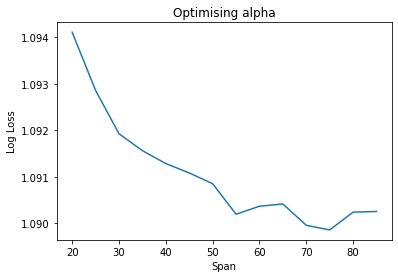

Our lowest log loss (1.089859) occurred at a span of 75


In [202]:
import matplotlib.pyplot as plt
plt.plot(list(range(20, 90, 5)), (pd.Series(cv_scores)*-1)) # Plot our results

plt.title("Optimising alpha")
plt.xlabel("Span")
plt.ylabel("Log Loss")
plt.show()

print("Our lowest log loss ({:2f}) occurred at a span of {}".format(best_score, best_span))

In [203]:
features_stats = create_stats_features_ema(stats, span=best_span)
features_stats.tail(3)

,id,team,home_game,corners_against,corners_for,frees_against,frees_for,goals_against,goals_for,reds_against,reds_for,shots_against,shots_for,shots_on_target_against,shots_on_target_for,yellows_against,yellows_for
6077,4767,Watford,1,6.172303,4.385713,10.629954,12.113886,1.321310,1.021054,0.077718,0.089370,11.812783,10.711964,6.263818,5.652388,1.228884,1.978950
6078,4768,West Bromwich Albion,1,5.586176,5.001793,10.740431,10.552447,1.331041,0.966388,0.117449,0.058731,12.831688,9.324837,6.928639,4.520602,1.247133,1.654127
6079,4768,Sunderland,0,5.947354,4.345448,11.288606,11.181531,1.560686,1.130225,0.114968,0.080617,13.883504,10.022196,7.572589,4.912204,1.794005,1.982218


In [ ]:
def create_multiline_df_betting(betting):
    multi_line_odds = betting[['gameId', 'home_team']] \
                      .rename(columns={'home_team': 'team'}) \
                      .append(betting[['gameId', 'away_team']]) \
                      .rename(columns={'away_team': 'team'}) \
                      .sort_values(by='gameId')\
                      .reset_index(drop=True)
    return multi_line_odds

def create_betting_features_ema(betting, span):
    multi_line_odds = create_multiline_df_betting(betting)
    
    ema_features = multi_line_odds[['gameId', 'team']].copy()

    feature_names = multi_line_odds.drop(columns=['gameId', 'team']).columns

    for feature_name in feature_names:
        feature_ema = (multi_line_odds.groupby('team')[feature_name]
                                      .transform(lambda row: row.ewm(span=span, min_periods=2)
                                      .mean()
                                      .shift(1)))

        ema_features[feature_name] = feature_ema
        
    return ema_features

# Create feature_odds df
features_odds = create_betting_features_ema(betting, span=10)
features_odds.tail(3)

# Escolher os algoritmos

Para analisarmos os dados escolhemos os algoritmos Logistic Regression, K-Nearest-Neighbours e Support Vector Machines pois são os mais adequados para os dados que temos. 

In [283]:
from sklearn import linear_model, tree, discriminant_analysis, naive_bayes, ensemble, gaussian_process
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import log_loss, confusion_matrix

try:
    del matches["possession"]
    del matches["corner"]
    del matches["card"]
    del matches["foul"]
    del matches["shoton"]
    del matches["shotoff"]
except KeyError:
    print("Already deleted")
    
matches = matches.assign(result=lambda df: df.apply(
                            lambda row: 'home' if row.home_team_goal > row.away_team_goal else ('draw' if row.home_team_goal == row.away_team_goal else 'away'), axis=1))
matches.head()

matches = matches.fillna(matches.mean())
matches = matches.rename(columns={
        'B365H': 'f_homeOdds',
        'B365A': 'f_awayOdds',
        'B365D': 'f_drawOdds'
        })

matches.head()


feature_list = [col for col in matches.columns if col.startswith("f_")]
betting_matches = []

le = LabelEncoder() # Initiate a label encoder to transform the labels 'away', 'draw', 'home' to 0, 1, 2

# Grab all seasons except for 17/18 to use CV with
all_x = matches.loc[matches.season != '2015/2016', ['id'] + feature_list]
all_y = matches.loc[matches.season != '2015/2016', 'result']
all_y = le.fit_transform(all_y)

# Create our training vector as the seasons except 16/17 and 17/18
train_x = matches.loc[~matches.season.isin(['2014/2015', '2015/2016']), ['id'] + feature_list]
train_y = le.transform(matches.loc[~matches.season.isin(['2014/2015', '2015/2016']), 'result'])

# Create our holdout vectors as the 16/17 season
holdout_x = matches.loc[matches.season == '2014/2015', ['id'] + feature_list]
holdout_y = le.transform(matches.loc[matches.season == '2014/2015', 'result'])

# Create our test vectors as the 17/18 season
test_x = matches.loc[matches.season == '2015/2016', ['id'] + feature_list]
test_y = le.transform(matches.loc[matches.season == '2015/2016', 'result'])

# Create a list of standard classifiers
classifiers = [

    #GLM
    linear_model.LogisticRegressionCV(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
]

def find_best_algorithms(classifier_list, X, y):
    # This function is adapted from https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling
    # Cross validate model with Kfold stratified cross validation
    kfold = StratifiedKFold(n_splits=5)
    
    # Grab the cross validation scores for each algorithm
    cv_results = [cross_val_score(classifier, X, y, scoring = "neg_log_loss", cv = kfold) for classifier in classifier_list]
    cv_means = [cv_result.mean() * -1 for cv_result in cv_results]
    cv_std = [cv_result.std() for cv_result in cv_results]
    algorithm_names = [alg.__class__.__name__ for alg in classifiers]
    
    # Create a DataFrame of all the CV results
    cv_results = pd.DataFrame({
        "Mean Log Loss": cv_means,
        "Log Loss Std": cv_std,
        "Algorithm": algorithm_names
    }).sort_values(by='Mean Log Loss')
    return cv_results

algorithm_results = find_best_algorithms(classifiers, all_x, all_y)

algorithm_results

        id  f_homeOdds  f_drawOdds  f_awayOdds
2280  4009        1.25        6.50       15.00
2281  4010        9.00        5.00        1.40
2282  4011        3.20        3.40        2.40
2283  4012        1.33        5.75       10.00
2284  4013        1.36        5.00       11.00
...    ...         ...         ...         ...
2655  4384        5.50        3.80        1.73
2656  4385        1.95        3.70        4.20
2657  4386        1.75        3.90        5.00
2658  4387        1.91        3.60        4.50
2659  4388        6.50        4.50        1.55

[380 rows x 4 columns]


,Mean Log Loss,Log Loss Std,Algorithm
0,0.968637,0.019637,LogisticRegressionCV
1,1.061597,0.000514,BernoulliNB
2,1.327429,0.177624,GaussianNB


In [285]:
import warnings

# Define our parameters to run a grid search over
lr_grid = {
    "C": [0.0001, 0.01, 0.05, 0.2, 1],
    "solver": ["newton-cg", "lbfgs", "liblinear"]
}

kfold = StratifiedKFold(n_splits=5)

gs = GridSearchCV(LogisticRegression(), param_grid=lr_grid, cv=kfold, scoring='neg_log_loss')
gs.fit(all_x, all_y)
print("Best log loss: {}".format(gs.best_score_ *-1))
best_lr_params = gs.best_params_

# Get test predictions

lr = LogisticRegression(**best_lr_params) # Instantiate the model
lr.fit(train_x, train_y) # Fit our model
lr_predict = lr.predict(holdout_x) # Predict the holdout values

test_lr = LogisticRegression(**best_lr_params)
test_lr.fit(all_x, all_y)
test_predictions_probs = lr.predict_proba(test_x)
test_predictions = lr.predict(test_x)

test_ll = log_loss(test_y, test_predictions_probs)
test_accuracy = (test_predictions == test_y).mean()

print("Our predictions for the 2017/18 season have a log loss of: {0:.5f} and an accuracy of: {1:.2f}".format(test_ll, test_accuracy))

# Get accuracy and log loss based on the odds
odds_ll = log_loss(test_y, 1 / test_x[['f_awayOdds', 'f_drawOdds', 'f_homeOdds']])

odds_predictions = test_x[['f_awayOdds', 'f_drawOdds', 'f_homeOdds']].apply(lambda row: row.idxmin()[2:6], axis=1).values
odds_accuracy = (odds_predictions == le.inverse_transform(test_y)).mean()

print("Odds predictions for the 2017/18 season have a log loss of: {0:.5f} and an accuracy of: {1:.3f}".format(odds_ll, odds_accuracy))

c:\users\gonca\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\linesearch.py:426: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
c:\users\gonca\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\users\gonca\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
c:\users\gonca\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\linesearch.py:426: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
c:\users\gonca\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not conv

Best log loss: 0.9684228400302028
Our predictions for the 2017/18 season have a log loss of: 1.03831 and an accuracy of: 0.46
Odds predictions for the 2017/18 season have a log loss of: 1.03524 and an accuracy of: 0.471
